In [ ]:
#Antes de iniciar é necessária a instalação dos pacotes necessários. Pacotes requests e time são nativos da linguagem e não precisam ser instalados.
!pip install pandas seaborn matplotlib

In [3]:
#Realizamos o import dos pacotes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from time import sleep

#Lemos o arquivo inicial
df_inicial = pd.read_csv('dados_iniciais.csv')

#trazemos informação de quantidade de linhas e colunas e trazemos uma visão das primeiras 5 linhas do arquivo.
print(f'df_shape: {df_inicial.shape}')
df_inicial.head()

df_shape: (20, 4)


,cnpj,data_inicial,cep,cnae_riginal
0,42.013.551/0001-30,2021-06-18 14:34:42+00,81150-090,7490-1/04
1,39.922.063/0001-30,2021-06-19 00:25:32+00,30455-610,4781-4/00
2,40.916.606/0001-96,2021-06-21 15:53:22+00,69309-012,7319-0/02
3,41.461.512/0001-32,2021-06-21 16:53:03+00,59215-000,7319-0/02
4,35.865.947/0001-40,2021-06-21 17:44:52+00,72220-263,4755-5/02


In [4]:
#Como iremos realizar uma consulta em api, criaremos uma função para melhor aproveitamento do código.
#De acordo com a documentação da API, para a consulta é necessário que o cnpj tenha 14 dígitos e sem caracteres especiais.
#Além disso, também é necessário respeitar uma frequência de 3 consultas por minuto.

def consultar_api(cnpj:str):
    """"
    Essa função realiza a consulta de um cpnj na api da receita federal (gratuita) com limite de 3 consultas por minuto
    """
    url = f'https://receitaws.com.br/v1/cnpj/{cnpj}'
    response = requests.request('GET', url, timeout=65)
    dados = response.json()
    return dados

In [5]:
#Aqui iremos remover os caracteres especiais da coluna referente ao cnpj das empresas.
df_inicial['cnpj'] = df_inicial['cnpj'].apply(lambda k: k.replace('.', '').replace('/', '').replace('-',''))

df_inicial.head()

,cnpj,data_inicial,cep,cnae_riginal
0,42013551000130,2021-06-18 14:34:42+00,81150-090,7490-1/04
1,39922063000130,2021-06-19 00:25:32+00,30455-610,4781-4/00
2,40916606000196,2021-06-21 15:53:22+00,69309-012,7319-0/02
3,41461512000132,2021-06-21 16:53:03+00,59215-000,7319-0/02
4,35865947000140,2021-06-21 17:44:52+00,72220-263,4755-5/02


In [6]:
#Criaremos uma lista que irá armazenar os resultados da consulta, com apenas as colunas necessárias para após ser criado um DataFrame.
enriquecimento = []
consulta = 0 #índice do número da consulta
lista_titulos = ['cnpj', 'data_abertura', 'nome', 'atividade_principal', 'atividade_secundaria', 'ultima_atualizacao', 'capital_social'] #Lista para salvar infos como dicionários

for k in df_inicial.index:
    try:
        #Validação para respeitar o limite de tempo entre as consultas na api
        if consulta == 3:
            print('Aguardar tempo limite de consulta na API.')
            sleep(65)
            consulta = 0

        #Tratamento de dados com resultados da API
        dados = consultar_api(df_inicial['cnpj'][k])
        cnpj = str(df_inicial['cnpj'][k])
        data_abertura = dados['abertura']
        nome = dados['nome']
        atividade_principal = dados['atividade_principal'][0]['code']
        try:
            atividade_secundaria = dados['atividades_secundarias'][0]['code']
        except:
            atividade_secundaria = 'nao_possui'
        ultima_atualizacao = dados['ultima_atualizacao']
        capital_social= dados['capital_social']

        lista_dados = [cnpj, data_abertura, nome, atividade_principal, atividade_secundaria, ultima_atualizacao, capital_social]
        resultado = dict(zip(lista_titulos, lista_dados)) #Zipando resultado para se tonar um dict

        enriquecimento.append(resultado)
        print(f'Consulta do cnpj {df_inicial['cnpj'][k]} realizada com sucesso!')
        consulta += 1

    except Exception as e:
        #Caso haja um erro, será printado na tela.
        print(f'Não foi possível realizar consulta pelo seguinte erro: {e}')


Consulta do cnpj 42013551000130 realizada com sucesso!
Consulta do cnpj 39922063000130 realizada com sucesso!
Consulta do cnpj 40916606000196 realizada com sucesso!
Aguardar tempo limite de consulta na API.
Consulta do cnpj 41461512000132 realizada com sucesso!
Consulta do cnpj 35865947000140 realizada com sucesso!
Consulta do cnpj 36931922000160 realizada com sucesso!
Aguardar tempo limite de consulta na API.
Consulta do cnpj 36149348000192 realizada com sucesso!
Consulta do cnpj 41665075000179 realizada com sucesso!
Consulta do cnpj 41182405000175 realizada com sucesso!
Aguardar tempo limite de consulta na API.
Consulta do cnpj 37204421000144 realizada com sucesso!
Consulta do cnpj 33633857000106 realizada com sucesso!
Consulta do cnpj 37654828000173 realizada com sucesso!
Aguardar tempo limite de consulta na API.
Consulta do cnpj 24302781000137 realizada com sucesso!
Consulta do cnpj 37145986000106 realizada com sucesso!
Consulta do cnpj 30909004000158 realizada com sucesso!
Aguarda

In [7]:

#Realizadas as consultas, iremos juntar os dados em um único DataFrame e tratar as colunas atividade principal e secundária, removendo caracteres especiais além de tratar as datas para o mesmo padrão.
dados_enriquecidos = pd.DataFrame(enriquecimento)
dados_enriquecidos['atividade_principal'] = dados_enriquecidos['atividade_principal'].apply(lambda k: k.replace('.', '').replace('/', '').replace('-',''))
dados_enriquecidos['atividade_secundaria'] = dados_enriquecidos['atividade_secundaria'].apply(lambda k: k.replace('.', '').replace('/', '').replace('-',''))
dados_enriquecidos['data_abertura'] =  pd.to_datetime(dados_enriquecidos['data_abertura'], dayfirst=True).dt.strftime('%Y-%m-%d %H:%M:%S')
dados_enriquecidos['ultima_atualizacao'] =  pd.to_datetime(dados_enriquecidos['ultima_atualizacao'], dayfirst=True, format='mixed').dt.strftime('%Y-%m-%d %H:%M:%S')

display(dados_enriquecidos)

#Realizados os tratamentos de dados, iremos salvar o arquivo em csv.
dados_enriquecidos.to_csv('dados_enriquecidos.csv', index=False, sep=';', encoding='utf-8')

,cnpj,data_abertura,nome,atividade_principal,atividade_secundaria,ultima_atualizacao,capital_social
0,42013551000130,2021-05-19 00:00:00,CSA INTERMEDIACAO EM COMPRAS COLETIVAS LTDA,7490104,5911102,2024-06-06 12:04:09,1000.00
1,39922063000130,2020-11-26 00:00:00,KIFA ROUPAS E ACESSORIOS LTDA.,0000000,0000000,2024-05-11 23:59:59,20000.00
2,40916606000196,2021-02-19 00:00:00,PEDRO IVO PRATA DE BARROS 55626831215,0000000,0000000,2024-05-11 23:59:59,1000.00
3,41461512000132,2021-04-05 00:00:00,DOUGLAS GOMES COUTINHO 01758766492,0000000,0000000,2024-05-11 23:59:59,1000.00
4,35865947000140,2019-12-30 00:00:00,KAREN MONTEIRO DE SOUSA 05185995157,0000000,0000000,2024-05-11 23:59:59,5000.00
5,36931922000160,2020-04-14 00:00:00,REGILENE GOMES BEZERRA 16144278877,0000000,0000000,2024-05-11 23:59:59,100.00
6,36149348000192,2020-01-27 00:00:00,FELIPE VAGNER DA SILVA 43061217800,0000000,0000000,2024-05-11 23:59:59,2000.00
7,41665075000179,2021-04-22 00:00:00,DSL NEGOCIOS DIGITAIS LTDA,7490104,5819100,2024-06-07 12:30:43,38600.00
8,41182405000175,2021-03-11 00:00:00,DAIANE DA SILVA,0000000,0000000,2024-05-11 23:59:59,10000.00
9,37204421000144,2020-05-21 00:00:00,VANESSA CORDEIRO LIMA 30880588861,0000000,0000000,2024-05-11 23:59:59,1000.00


P1: Partindo do CSV original contendo os CNPJs, supondo que o csv seja a tabela empresas em um banco de dados relacional, qual das datas que mais aparece?

In [8]:
#Para responder a essa pergunta, será criada uma coluna contendo apenas a data sem horas, minutos e segundos.
df_inicial['data'] =  pd.to_datetime(df_inicial['data_inicial'], dayfirst=True, format='mixed').dt.strftime('%Y-%m-%d')

#Pelo métoo groupby será definido uma tabela de frequências para as datas.
data_maior_frequencia = df_inicial.groupby('data', as_index=False)['data'].agg(qtd='count').sort_values(by='qtd',ascending=False).reset_index(drop=True)

#Por fim será impresso na tela a data que tem maior frequência.
print(f'A data que mais aparece é a data {data_maior_frequencia['data'][0]}, que aparece um total de {data_maior_frequencia['qtd'][0]} vezes.')


A data que mais aparece é a data 2021-06-28, que aparece um total de 5 vezes.


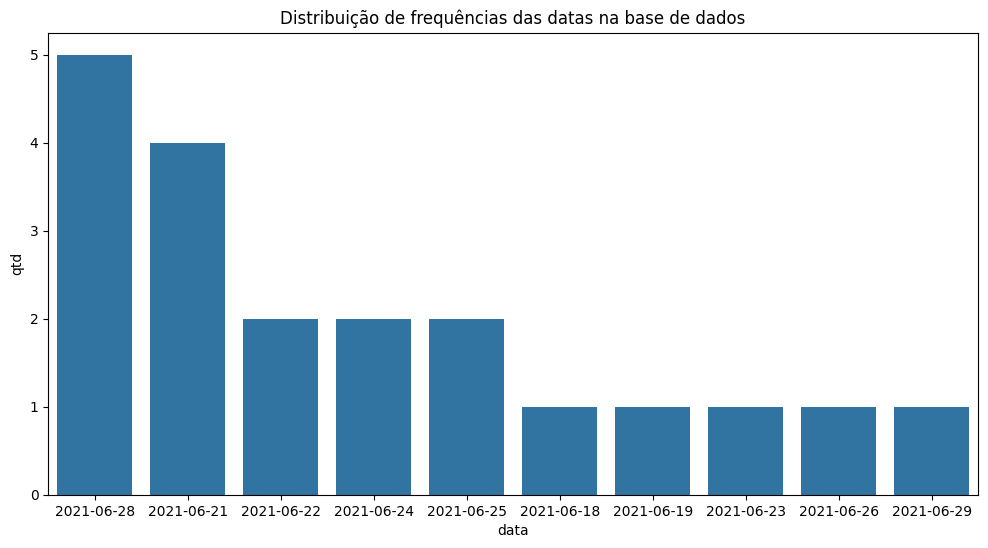

In [9]:
#Gráfico mostrando a distribuição de frequências da base.
plt.figure(figsize=(12,6))
sns.barplot(data=data_maior_frequencia, x='data', y='qtd')
plt.title('Distribuição de frequências das datas na base de dados')
plt.show()

P2: Precisamos que seja elaborada uma consulta SQL que atribua uma posição ou
classificação a cada linha, com base na quantidade de datas, ordenando as de forma
decrescente.

In [15]:
#Para reponder à essa pergunta, criaremos um banco de dados local com o sqlite afim de simular o problema proposto.
import sqlite3

conn = sqlite3.connect('empresas.db')
cursor = conn.cursor()

try:
    df_inicial.to_sql('df_inicial', conn, if_exists='replace') #Salvando nosso csv original diretamente na base de dados.
    print('Tabela criada')
except Exception as f:
    print(f'Não foi possível criar tabela. Erro:{f}')

Tabela criada


In [11]:
#Com a tabela criada agora podemos realizar uma query que irá rankear as linhas de acordo com a quantidade de vezes que a data aparece.

df_ordenado = pd.read_sql_query("""
WITH contagem as (

    SELECT

        data,
        COUNT(data) as contagem

    FROM df_inicial

    GROUP BY 1
)
    SELECT

        emp.cnpj,
        emp.data_inicial,
        emp.cep,
        emp.cnae_riginal,
        emp.data,
        ct.contagem as qtd_vezes_data,
        RANK() OVER (ORDER BY ct.contagem DESC) AS rank

    FROM df_inicial as emp
        LEFT JOIN contagem as ct on ct.data = emp.data

""", conn)

display(df_ordenado) #Por fim será demonstrado a query desenvolvida e sua eficácia


,cnpj,data_inicial,cep,cnae_riginal,data,qtd_vezes_data,rank
0,30909004000158,2021-06-28 13:23:47+00,30411-515,7319-0/02,2021-06-28,5,1
1,41884167000140,2021-06-28 15:19:41+00,88702-704,4763-6/02,2021-06-28,5,1
2,40164422000117,2021-06-28 17:40:55+00,29062-545,4772-5/00,2021-06-28,5,1
3,40281052000106,2021-06-28 18:05:39+00,32241-250,7319-0/02,2021-06-28,5,1
4,39854502000115,2021-06-28 22:01:38+00,41745-040,7319-0/02,2021-06-28,5,1
5,40916606000196,2021-06-21 15:53:22+00,69309-012,7319-0/02,2021-06-21,4,6
6,41461512000132,2021-06-21 16:53:03+00,59215-000,7319-0/02,2021-06-21,4,6
7,35865947000140,2021-06-21 17:44:52+00,72220-263,4755-5/02,2021-06-21,4,6
8,36931922000160,2021-06-21 18:10:26+00,09784-395,4772-5/00,2021-06-21,4,6
9,36149348000192,2021-06-22 10:57:27+00,06814-105,7319-0/02,2021-06-22,2,10


In [16]:
#Outro possibilidade é utilizar a função ROW_NUMBER() para adicionar um índice a cada linha

df_ordenado2 = pd.read_sql_query("""
WITH contagem as (

    SELECT

        data,
        COUNT(data) as contagem

    FROM df_inicial

    GROUP BY 1
)
    SELECT

        emp.cnpj,
        emp.data_inicial,
        emp.cep,
        emp.cnae_riginal,
        emp.data,
        ct.contagem as qtd_vezes_data,
        ROW_NUMBER() OVER (ORDER BY ct.contagem DESC) AS posicao

    FROM df_inicial as emp
        LEFT JOIN contagem as ct on ct.data = emp.data

""", conn)

display(df_ordenado2) #Por fim será demonstrado a query desenvolvida e sua eficácia
conn.close()

,cnpj,data_inicial,cep,cnae_riginal,data,qtd_vezes_data,posicao
0,30909004000158,2021-06-28 13:23:47+00,30411-515,7319-0/02,2021-06-28,5,1
1,41884167000140,2021-06-28 15:19:41+00,88702-704,4763-6/02,2021-06-28,5,2
2,40164422000117,2021-06-28 17:40:55+00,29062-545,4772-5/00,2021-06-28,5,3
3,40281052000106,2021-06-28 18:05:39+00,32241-250,7319-0/02,2021-06-28,5,4
4,39854502000115,2021-06-28 22:01:38+00,41745-040,7319-0/02,2021-06-28,5,5
5,40916606000196,2021-06-21 15:53:22+00,69309-012,7319-0/02,2021-06-21,4,6
6,41461512000132,2021-06-21 16:53:03+00,59215-000,7319-0/02,2021-06-21,4,7
7,35865947000140,2021-06-21 17:44:52+00,72220-263,4755-5/02,2021-06-21,4,8
8,36931922000160,2021-06-21 18:10:26+00,09784-395,4772-5/00,2021-06-21,4,9
9,36149348000192,2021-06-22 10:57:27+00,06814-105,7319-0/02,2021-06-22,2,10
